# Outline

* setup
* run all pipelines, pyannote, baselines + tinydiarize
* compile scored results and compare
* dive into `pre_sr` baseline errors
* diff with punctuation baseline
* diff with joint sr approach in `tinydiarize`
* misc information w.r.t. tinydiarize

TBD - where to insert the post_sr part, and discussion on integration with clustering

# Setup


Add a note to follow setup instructions in tinydiarize/README.md

In [4]:
from IPython import display as ipd
from IPython import get_ipython
from pathlib import Path

In [147]:
import os
import re
import glob
import pandas as pd
import matplotlib.pyplot as plt
# edit matplotlib theme to a better looking one
plt.style.use('seaborn-v0_8-notebook')

In [6]:
# setup: we need to get tinydiarize files from git repo, install other dependencies, and fetch eval data for analysis
# update: google colab wont be possible as score.py uses docker to run fstalign which is not supported by colab
# so will have to use pre-computed results

if 'google.colab' in str(get_ipython()):
    # clone a particular branch of tinydiarize repo
    ! git clone https://github.com/akashmjn/tinyDiarize.git -b analysis-1 --single-branch
    # pip install 
    ! pip install -e tinyDiarize 
    # setup workdir
    WORKDIR = 'tinyDiarize/tinydiarize/workdir_analysis'
    CODEDIR = 'tinyDiarize/tinydiarize'
    # download pre-computed results from blob
    ! wget -O {CODEDIR}/workdir_analysis.tar.gz https://sharedstorage7190.blob.core.windows.net/tinydiarize/precomputed/workdir_analysis/5e09d4787a2674ea773547dcb9f23321a472bea883917337e0139a2ba0c2dd34.tar.gz
    _PRE_COMPUTED = True
else:
    # if running locally, assume that tinydiarize repo is already cloned and installed
    WORKDIR = '../workdir_analysis'
    CODEDIR = '..'
    _PRE_COMPUTED = False

ipd.clear_output()

## Evaluation data

I evaluate in an out-of-distribution setup outside of the dataset that the model was finetuned on (AMI meetings). As done in Whisper, this allows us to get a more realistic estimate of real-world generalization vs the model's ability to fit dataset-specific quirks of the AMI dataset.

I've chosen 3 earnings calls from [rev/earnings21](https://github.com/revdotcom/speech-datasets/blob/main/earnings21/earnings21-file-metadata.csv). These were selected with the following criteria:
- One interactive Q&A meeting (Hershey) with a higher rate of speaker switches and unique speakers
- One meeting (Amex) that is moderated Q&A between only 2 speakers
- One meeting (Constellium) that is a presentation and Q&A session, and is somewhere in between

| file_id | audio_length | company_name | sector | speaker_switches | speaker_switches / minute | unique_speakers |
|---------|--------------|--------------|--------|------------------|---------------------------|-----------------|
| 4385939 | 3049.832     | Hershey Company | Consumer Goods | 132 | 2.60 | 19 |
| 4374910 | 2028.536     | American Express Company | Financial | 56 | 1.66 | 2 |
| 4359971 | 3759.944     | Constellium | Industrial Goods | 116 | 1.85 | 10 |

For ease of analysis, 

In [12]:
# make appropriate workdir structure and pull eval files inside it

if _PRE_COMPUTED:
    # unpack pre-computed results into WORKDIR
    ! tar -xzf {CODEDIR}/workdir_analysis.tar.gz -C {CODEDIR}
else:
    ! mkdir -p {WORKDIR}
    # call a bash script with WORKDIR as an environment variable
    ! bash {CODEDIR}/scripts/fetch_earnings21_calls.sh {WORKDIR}

ipd.clear_output()

In [ ]:
# can listen to first and last 2 minutes of an example file
ipd.Audio(f'{WORKDIR}/audio/earnings21-4359971.mp3')

## Transcribing

We transcribe the calls here using a pyannote + `small.en` pipeline, 2 simple native baselines (explained later in the notebook), and with the `small.en-tdrz` tinyDiarize model. Transcribed results are scored for both WER and accuracy of speaker turns.

> *NOTE: On Google colab, we will fetch pre-computed results from my runs, as it's a bit tricky to setup the fstalign scoring tool*

In [ ]:
if not _PRE_COMPUTED:
    # change directory to ../scripts 
    ! cd {CODEDIR}/scripts

    # process all the selected calls
    calls = [
        ("earnings21-4385939", 19),
        ("earnings21-4374910", 2),
        ("earnings21-4359971", 10),
    ]

    # iterate over calls and run the script run_pipelines.py
    for call_id, num_speakers in calls:
        ! python run_pipelines.py {WORKDIR}/audio/{call_id}.mp3 {WORKDIR}/fstalign_scoring/references/{call_id}-ref.nlp {WORKDIR}/transcripts/tiny.en/{call_id} --num_speakers {num_speakers}

    # change directory back to ../notebooks
    ! cd ./notebooks

# TODO@Akash - verify run_pipelines works, for now assuming that results are generated correctly

## Metrics

Show some examples of transcript, why WYSIWYG metric choice

In [ ]:
import sys
sys.path.append(CODEDIR)  # TODO@Akash - consider pip installing vs directly calling code files?
from score import parse_analysis_file

## Compiling results

To understand the gaps in current diarization approaches, compare on these meetings against two very simple baselines (segment, punctuation).

Provide some information about baselines. Each one adds `speaker_turns` in the following ways:
- `segment`: after every time segment created by whisper
- `punctuation`: after every ending punctuation e.g. `.?!`
- `drz_pre_sr`: full pyannote diarization pipeline, with ASR on recognized segments
- `drz_post_sr`: simple diarization that adds a clustering step after `segment`

In [117]:
# define some notebook utility functions

def compile_results(results_dir):
    # read and compile both scoring_results and analysis_results
    # compile all scoring_results.tsv files
    scored_tsvs = []
    tsv_list = glob.glob(f"{results_dir}/**/scoring_results.tsv", recursive=True)
    for tsv in tsv_list:
        scored_tsvs.append(pd.read_csv(tsv, sep="\t"))
    results_df = pd.concat(scored_tsvs)
    model, call_id, method = zip(
        *[re.search(r'(.*)__earnings21-([0-9]+)_+(.*)', r).groups() 
            for r in results_df.result_id]
    )
    model = [m.split("_")[0] for m in model]  # remove the suffix after -ft_*
    # rename some methods to more understandable names
    method_map = dict(
        drz_pre_sr__segment="pyannote_pre_sr", 
        segment="time_segment", 
        drz_post_sr__segment="time_segment_clustered"
    )
    method = [method_map.get(m, m) for m in method]
    results_df["model"], results_df["call_id"], results_df["method"] = model, call_id, method
    print(f"Read {len(results_df)} results from {len(tsv_list)} files")

    # # collect all side-by-side analysis results
    # analysis_results = dict()
    # sbs_list = glob.glob(f"../workdir_analysis/fstalign_scoring/results/{model_id}__**/spk_turn/results/*.sbs", recursive=True)
    # for sbs in sbs_list:
    #     # get the result_id from the path
    #     result_id = Path(sbs).parts[-4]
    #     precision_errors, recall_errors = parse_analysis_file(sbs)
    #     analysis_results[result_id] = dict(precision_errors=precision_errors, recall_errors=recall_errors)
    # print(f"Read {len(analysis_results)} analysis results")
    return results_df

def query_metric_results(results_df, metric, groups=["call_id", "method"]):
    """Query the results for a given metric"""
    metric_df = results_df.query(f'metric=="{metric}"').groupby(groups)["value"].first().unstack().round(2)
    return metric_df

def plot_metric_df(metric_df, title=None, ax=None, legend=True):
    # metric = metric_df.metric.iloc[0]
    if ax is None:
        ax = plt.gca()
    metric_df.plot.barh(title=title, ax=ax, legend=legend)
    if legend:
        # edit the legend of the plot so that it doesn't overlap with the plot
        _ = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

In [134]:
results_df = compile_results(f"{WORKDIR}/fstalign_scoring/results")
results_df.head()

Read 84 results from 21 files


,metric,value,denominator,numerator,deletions,insertions,substitutions,result_id,model,call_id,method
0,wer_overall,7.498897,9068,680,83,228,369,small.en-ft_decoder-frz_bpe_time_2-hp2.pt__ear...,small.en-ft,4385939,token
1,wer_speaker_switch,11.422846,998,114,27,31,56,small.en-ft_decoder-frz_bpe_time_2-hp2.pt__ear...,small.en-ft,4385939,token
2,spk_turn_precision,98.958328,96,95,0,1,0,small.en-ft_decoder-frz_bpe_time_2-hp2.pt__ear...,small.en-ft,4385939,token
3,spk_turn_recall,72.519081,131,95,30,0,6,small.en-ft_decoder-frz_bpe_time_2-hp2.pt__ear...,small.en-ft,4385939,token
0,wer_overall,13.713123,4915,674,360,71,243,small.en__earnings21-4374910_drz_pre_sr__segment,small.en,4374910,pyannote_pre_sr


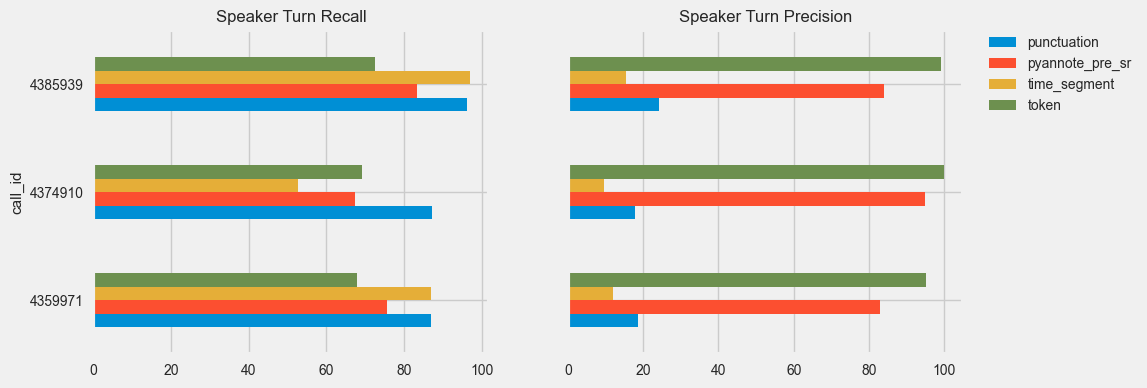

In [148]:
# comparing results for pyannote_pre_sr, time_segment, punctuation, token
subset_df = results_df.query('method not in ["time_segment_clustered"]')
subset_df = subset_df.query('~(model=="small.en-ft" and method != "token")')
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
d1 = query_metric_results(subset_df, "spk_turn_recall", groups=["call_id", "method"])
plot_metric_df(d1, title="Speaker Turn Recall", ax=axes[0], legend=False)
d2 = query_metric_results(subset_df, "spk_turn_precision", groups=["call_id", "method"])
plot_metric_df(d2, title="Speaker Turn Precision", ax=axes[1])

Very consistent performance. Finally, can look at a transcripts to get a better feel for what transcripts produced by ft-token look like 

need to look at side by side to properly understand the drawbacks/bottlnecks of diarization designs

- baselines actually have quite good recall, better than existing diarization approaches, at no extra cost (tabulate the cost).
- gap in recall between drz_post_sr and segment            (indicates ?)
- gap in precision errors for post sr on 9971 inspite of higher recall?  (indicates clustering errors)

(suprising that diarization pipelines work the worst on a call with only two speakers, should look into it)

overall, the gap between segment and drz_post_sr shows a lot of clustering errors. 

We can see that naively altering the segments in `drz_pre_sr` can have a significant (15%+ relative) negative impact on the WER. In regions around speaker switches the impact is much higher (40-70%), as segments tend to be much shorter here.

In [104]:
subset_df = results_df.query('method in ["pyannote_pre_sr", "time_segment"]')
print("WER impact of finetuning")
ipd.display(query_metric_results(subset_df.query('method=="time_segment"'), "wer_overall", groups=["call_id", "model"]))
# we see that after finetuning, the overall WER not impacted too much
print("WER impact of segmentation in pyannote_pre_sr")
ipd.display(query_metric_results(subset_df, "wer_overall", groups=["call_id", "method"]))
# ipd.display(query_metric_results(subset_df, "wer_speaker_switch", groups=["call_id", "method"]))
# pre-segmented recognition hurts WER, especially around speaker switches

WER impact of finetuning


model,small.en,small.en-ft
call_id,,
4359971,13.03,13.89
4374910,10.14,6.91
4385939,10.18,7.50


WER impact of segmentation in pyannote_pre_sr


method,pyannote_pre_sr,time_segment
call_id,,
4359971,19.58,13.03
4374910,13.71,6.91
4385939,14.32,7.50


## Error inspection

let's look at some examples to build intuition about what's going on 

todos: 
- change line number to reference word number
- make into class that stores original lines, configurable context 
- make a neat side-by-side fixed width print
- compare pre_sr and punctuation results 

The model already separates different speakers using punctuations very reliably, with high recall. 

In [35]:
model_id = "small.en"
call_id = "earnings21-4359971"
method = "__punctuation"
result_id = f"{model_id}__{call_id}{method}"

spk_turn_errors = analysis_results[result_id]
print(f"Precision errors: {len(spk_turn_errors['precision_errors'])}")
print(f"Recall errors: {len(spk_turn_errors['recall_errors'])}")

Precision errors: 438
Recall errors: 13


If we look at the few speaker turns that were missed, these mainly because whisper chose to ignore those words (SR error). For the words actually recognized, the model almost always (>90-95%) distinguishes different speakers. Confirms that is has a useful internal representation.

In [45]:
i = 12
print("Line:", spk_turn_errors["recall_errors"][i]["line"])
print(spk_turn_errors["recall_errors"][i]["context"])

Line: 9979
              rather	rather              			
                than	than                			
               later	later               			
               <ins>	speaker__turn       	ERR		
                 and	and                 			
                   i	i                   			
               think	think               		___100209_SYN_1-1___	
       speaker__turn	<del>               	ERR	___106_SPEAKER_TURN___	###106_###|
                 got	<del>               	ERR		
                 you	<del>               	ERR		
       speaker__turn	<del>               	ERR	___107_SPEAKER_TURN___	###107_###|
              people	people              			
                 are	are                 			
              seeing	seeing              			
                 the	the                 		___100210_SYN_1-1___	
                 the	<del>               	ERR		
          confidence	confidence          			
            building	building            			
                  up	up                  			
          

Now if we look for the speaker turns that were missed by pyannote, we can see that the errors are always around short, few-word segments.

In [8]:
model_id = "small.en"
call_id = "earnings21-4359971"
method = "_drz_pre_sr__segment"
result_id = f"{model_id}__{call_id}{method}"

spk_turn_errors = analysis_results[result_id]
print(f"Precision errors: {len(spk_turn_errors['precision_errors'])}")
print(f"Recall errors: {len(spk_turn_errors['recall_errors'])}")

Precision errors: 18
Recall errors: 24


In [33]:
i = 7
print("Line:", spk_turn_errors["recall_errors"][i]["line"])
print(spk_turn_errors["recall_errors"][i]["context"])

Line: 4794
                  on	on                  			
                that	that                			
               front	front               			
                  of	of                  			
                that	that                			
                  if	if                  			
                that	that                			
               comes	comes               			
                  to	to                  			
            fruition	fruition            			
       speaker__turn	<del>               	ERR	___23_SPEAKER_TURN___	###23_###|
                yeah	yeah                			
                well	well                			
               <ins>	speaker__turn       	ERR		
                   i	i                   			
                mean	mean                			
                  we	we                  			
             believe	believe             			
                it's	it's                			
                   a	<del>               	ERR		


This confirms the hypothesis that time resolution is clearly a limitation of indepedent pre-sr pipelines.

> TODO@Akash - enable diff between errors

> TODO@Akash - attempt to breakdown the misses from SR DELs vs misses in diarization

In [ ]:
# function to print two strings side-by-side with a fixed width
def print_side_by_side(s1, s2, width=50):
    # split the strings into lines
    s1_lines = s1.splitlines()
    s2_lines = s2.splitlines()
    # get the maximum number of lines
    max_lines = max(len(s1_lines), len(s2_lines))
    # pad the lines with empty strings
    s1_lines += [""] * (max_lines - len(s1_lines))
    s2_lines += [""] * (max_lines - len(s2_lines))
    # print the lines side-by-side
    for s1, s2 in zip(s1_lines, s2_lines):
        s1 = s1.rsplit('\t', 2)[0]  # remove the last 2 columns, keep only words and ERR hints
        s2 = s2.rsplit('\t', 2)[0]
        print(f"{s1: <{width}}{s2: <{width}}")

how to retain advantages?

looking closer we see why (insert nemo graphic on fidelity vs temporal resolution). this tradeoff comes at a significant extra cost (already quite expensive). even so, it is a patch on a fundamental drawback. SR models can easiliy output tokens at much higher time resolution, making it a much more natural choice. 
this will only yield local (within 30s chunk) - will still need a clustering process to group speakers across full timescale of meeting.

## Analysis of finetuned models

Here we look at Whisper models finetuned to detect speaker turns, partially solving the speaker-segmentation aspect of diarization. We want to see high accuracy with minimal impact on the WER.

Summary:
- the model makes very few spk turn predictions but with ~100% precision. these are likely already included within punctuations (should check if these were missed by time segments, or diarization)
- `drz_post_sr` clustering will still be needed. hope is that `speaker_turn` is predicted well difficult parts (short segments) acting in a complementary way to further improve clustering recall errors. to enable `drz_post_sr`, i need to modify decoding to force sample a timestamp when token is predicted
- since the model tends to be very precise, another `speaker_same` token could also help clustering precision errors, so that short segments still get assigned to the same speaker when there are larger # of speakers. in this case we'd skip sampling a timestamp to make a longer segment
- i've also noticed these undesirable regressions/gotchas:
    - the finetuned model spkturn_segments has significantly lower recall from ~ 80% -> 10%. probably because of training on a different (longer) distribution of segments in ami data. or that the model simply forgets to output timestamps
    - WER is quite different, some better or worse, with very different sub/ins/del pattern

The regressions are fixable with more modular and careful finetuning. But first, will aim to check if finetuning can actually improve.